In [ ]:
!pip install keras

In [ ]:
!pip install hdf5storage
!git clone https://github.com/adityajn105/brain-tumor-segmentation-unet
!bash brain-tumor-segmentation-unet/download_data.sh
!python brain-tumor-segmentation-unet/mat_to_numpy.py brain_tumor_dataset/

     |████████████████████████████████| 61kB 5.4MB/s 
Cloning into 'brain-tumor-segmentation-unet'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 37 (delta 5), reused 32 (delta 4), pack-reused 0
Unpacking objects: 100% (37/37), done.
3064
[3064/3064] images loaded: 100.0 %tcmalloc: large alloc 1606418432 bytes == 0x56558bb64000 @  0x7f9af3f251e7 0x7f9af1aa546e 0x7f9af1af5c7b 0x7f9af1af8e83 0x7f9af1af907b 0x7f9af1b9a761 0x5654f91fdcc0 0x5654f91fda50 0x5654f9271be0 0x5654f926c4ae 0x5654f926c1b3 0x5654f9336182 0x5654f93364fd 0x5654f93363a6 0x5654f930d723 0x5654f930d3cc 0x7f9af2d0fbf7 0x5654f930d2aa

labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy saved in brain_tumor_dataset/


# **Data preprocessing and visulization**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

##Load images, labels, masks
labels = np.load('brain_tumor_dataset/labels.npy')
images = np.clip( (np.load('brain_tumor_dataset/images.npy')/12728),0,1)
masks = np.load('brain_tumor_dataset/masks.npy')*1
print(labels.shape)
print(images.shape)
print(masks.shape)

(3064,)
(3064, 512, 512)
(3064, 512, 512)


In [ ]:
labels2 = labels
print(labels)
print(labels2)
print(labels2.shape)
print(type(labels2))

[2 2 1 ... 2 3 2]
[2 2 1 ... 2 3 2]
(3064,)
<class 'numpy.ndarray'>


In [ ]:
from skimage.transform import resize
img_size_ori = 512
img_size_target = 128

#images = np.expand_dims(images,axis=-1)
#masks = np.expand_dims(masks,axis=-1)

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True,)
    
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
  
images = np.array([ downsample(image) for image in images ])
masks = (np.array([ downsample(mask) for mask in masks ])>0)*1

print(images.shape)
print(masks.shape) 
print(labels.shape) 

(3064, 128, 128)
(3064, 128, 128)
(3064,)


In [ ]:
import pandas as pd
add_columns = pd.get_dummies(labels)
print(add_columns.index)


RangeIndex(start=0, stop=3064, step=1)


In [ ]:
df = pd.DataFrame(labels, columns = ['label'])

In [ ]:
merged = pd.concat([df, add_columns], axis = 'columns')
merged.head()

,label,1,2,3
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,3,0,0,1
4,1,1,0,0


In [ ]:
merged.to_numpy()

array([[2, 0, 1, 0],
       [2, 0, 1, 0],
       [1, 1, 0, 0],
       ...,
       [2, 0, 1, 0],
       [3, 0, 0, 1],
       [2, 0, 1, 0]])

In [ ]:
final = merged.drop(['label'], axis = 'columns')


In [ ]:
labels = final.to_numpy()

[ 708 1426  930]


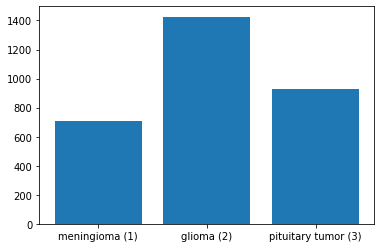

In [ ]:
classes, counts = np.unique(labels2,return_counts=True)
plt.bar(classes,counts,tick_label=list(integer_to_class.values()))
print(counts)

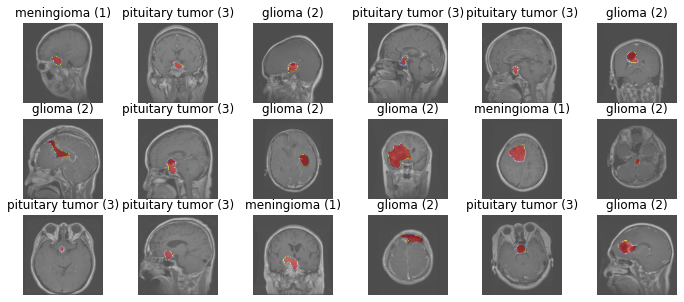

In [ ]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( images[idx], cmap='gray')
    plt.imshow( np.ones_like(masks[idx])-masks[idx], alpha=0.5, cmap='Set1')
    plt.title(integer_to_class[str(labels2[idx])])
    plt.axis('off')

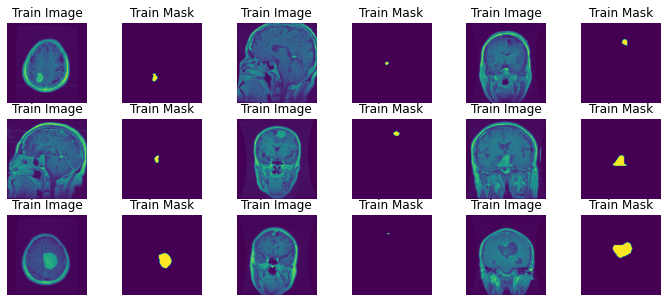

In [ ]:
plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint( images.shape[0], size=9):
  plt.subplot(3,6,i);i+=1
  plt.imshow( images[idx])
  plt.title("Train Image")
  plt.axis('off')
  plt.subplot(3,6,i);i+=1
  plt.imshow( masks[idx]) 
  plt.title("Train Mask")
  plt.axis('off')

changing labels numbering to 0,1,2

In [ ]:
import pandas as pd
labels2 = pd.DataFrame(labels2,columns=['labels2'])
labels2 = labels2-1


In [ ]:
images1 = np.resize(images,(3064,16384))
images1 = pd.DataFrame(images1)


In [ ]:
masks1 = np.resize(masks,(3064,16384))
masks1 = pd.DataFrame(masks1)
labels = pd.DataFrame(labels,columns=['1', '2', '3'])


In [ ]:
from sklearn.model_selection import train_test_split

X,X_v,Y,Y_v = train_test_split( images1,masks1,test_size=0.2,stratify=labels)

X.shape,X_v.shape

((2451, 16384), (613, 16384))

In [ ]:
labels2_train = labels2.loc[list(X.index),:]
labels2_val = labels2.loc[list(X_v.index),:]

In [ ]:
labels_train = labels.loc[list(X.index),:]
labels_val = labels.loc[list(X_v.index),:]
print(labels_train.shape)
print(type(labels_train))
print(labels_val.shape)
print(type(labels_val))

(2451, 3)
<class 'pandas.core.frame.DataFrame'>
(613, 3)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
X = np.resize(X.values,(2451,128,128))
X_v = np.resize(X_v.values,(613,128,128))
Y = np.resize(Y.values,(2451,128,128))
Y_v = np.resize(Y_v.values,(613,128,128))

In [ ]:
X=np.expand_dims(X,axis=-1)
Y=np.expand_dims(Y,axis=-1)
X_v=np.expand_dims(X_v,axis=-1)
Y_v=np.expand_dims(Y_v,axis=-1)

In [ ]:
X = np.append( X, [ np.fliplr(x) for x in X], axis=0 )
Y = np.append( Y, [ np.fliplr(y) for y in Y], axis=0 )
X.shape,Y.shape

((4902, 128, 128, 1), (4902, 128, 128, 1))

In [ ]:
labels_train = labels_train.append(labels_train)
print(labels.shape)
print(labels_train.shape)
print(labels_val.shape)

(3064, 3)
(4902, 3)
(613, 3)


In [ ]:
X = np.append( X, [ np.flipud(x) for x in X], axis=0 )
Y = np.append( Y, [ np.flipud(y) for y in Y], axis=0 )
X.shape,Y.shape

((9804, 128, 128, 1), (9804, 128, 128, 1))

In [ ]:
labels_train = labels_train.append(labels_train)
print(labels.shape)
print(labels_train.shape)
print(labels_val.shape)

(3064, 3)
(9804, 3)
(613, 3)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(brightness_range=(0.9,1.1),
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator()
X.shape, Y.shape
labels.shape

(3064, 3)

In [ ]:
labels_train.to_numpy()
labels_val.to_numpy()
print(labels_train.shape)
print(type(labels_train))
print(labels_val.shape)
print(type(labels_val))

(9804, 3)
<class 'pandas.core.frame.DataFrame'>
(613, 3)
<class 'pandas.core.frame.DataFrame'>


# **Model Training**

In [ ]:
from keras.losses import *
from keras import backend as K
import tensorflow as tf
from keras.layers import *
from keras import optimizers
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

defining model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 128, 128, 64) 137         input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 128, 128, 64) 4736        separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_2 (SeparableCo (None, 128, 128, 64) 129         input_1[0][0]                    
______________________________________________________________________________________________

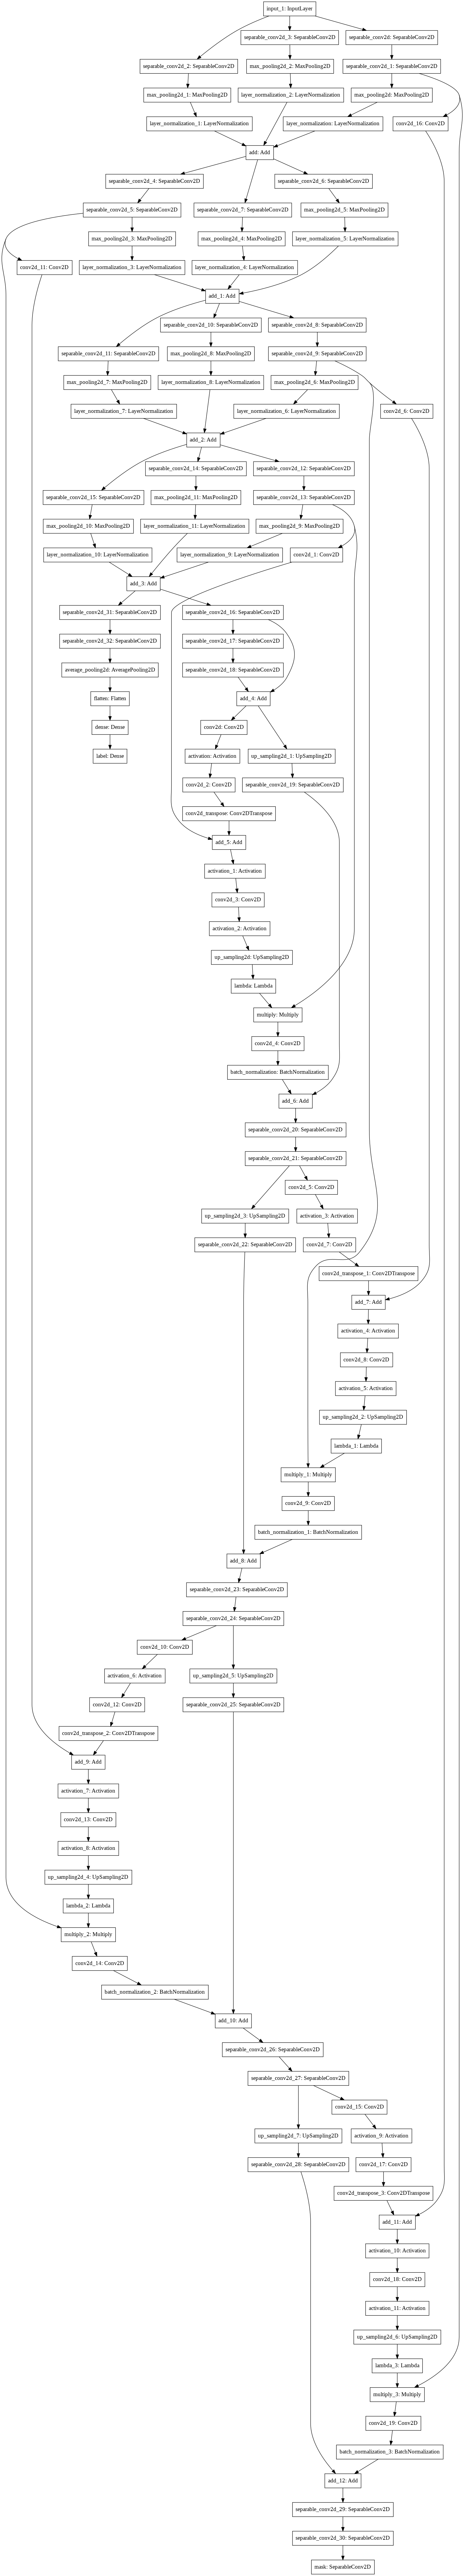

In [ ]:
from keras.layers import SeparableConv2D
IMG_DIM = (128,128,1)
FILTER_NUM = 3
batch_norm = False
'''
Definitions of loss and evaluation metrices
'''
def expend_as(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :param input:   down-dim feature map
    :param out_size:output channel number
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3])

    y = multiply([upsample_psi, x])

    result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = BatchNormalization()(result)
    return result_bn

inp = Input( shape=IMG_DIM )
FILTER_NUM = 3
conv1 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inp)
conv1 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
conv12 = SeparableConv2D(64, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inp)
conv13 = SeparableConv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inp) 
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = LayerNormalization()(pool1)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
pool12 = LayerNormalization()(pool12)
pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)
pool13 = LayerNormalization()(pool13)
m1 = Add()([pool1, pool12, pool13])


conv2 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m1)
conv2 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv21 = SeparableConv2D(128, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m1)
conv23 = SeparableConv2D(128, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m1) 
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = LayerNormalization()(pool2)
pool22 = MaxPooling2D(pool_size=(2, 2))(conv23)
pool22 = LayerNormalization()(pool22)
pool23 = MaxPooling2D(pool_size=(2, 2))(conv21)
pool23 = LayerNormalization()(pool23)
m2 = Add()([pool2, pool22, pool23])

conv3 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m2)
conv3 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
conv31 = SeparableConv2D(256, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m2)
conv32 = SeparableConv2D(256, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m2) 
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
pool3 = LayerNormalization()(pool3)
pool32 = MaxPooling2D(pool_size=(2, 2))(conv32)
pool32 = LayerNormalization()(pool32)
pool33 = MaxPooling2D(pool_size=(2, 2))(conv31)
pool33 = LayerNormalization()(pool33)
m3 = Add()([pool3, pool32, pool33])

conv4 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m3)
conv4 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv41 = SeparableConv2D(512, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m3)
conv42 = SeparableConv2D(512, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m3) 
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
pool4 = LayerNormalization()(pool4)
pool42 = MaxPooling2D(pool_size=(2, 2))(conv42)
pool42 = LayerNormalization()(pool42)
pool43 = MaxPooling2D(pool_size=(2, 2))(conv41)
pool43 = LayerNormalization()(pool43)
m4 = Add()([pool4, pool42, pool43])

c5 = SeparableConv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m4)
conv5 = SeparableConv2D(1024, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(c5)
conv5 = SeparableConv2D(1024, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
conv5 = Add()([conv5, c5])


gating_16 = gating_signal(conv5, 8*FILTER_NUM, batch_norm)
att_16 = attention_block(conv4, gating_16, 8*FILTER_NUM)
up6 = SeparableConv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
merge6 = Add()([up6, att_16])
upconv6 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
upconv6 = SeparableConv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(upconv6)

gating_32 = gating_signal(upconv6, 4*FILTER_NUM, batch_norm)
att_32 = attention_block(conv3, gating_32, 4*FILTER_NUM)
up7 = SeparableConv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(upconv6))
merge7 = Add()([att_32, up7])
upconv7 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
upconv7 = SeparableConv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(upconv7)

gating_64 = gating_signal(upconv7, 2*FILTER_NUM, batch_norm)
att_64 = attention_block(conv2, gating_64, 2*FILTER_NUM)
up8 = SeparableConv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(upconv7))
merge8 = Add()([att_64,up8])
upconv8 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
upconv8 = SeparableConv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(upconv8)

gating_128 = gating_signal(upconv8, FILTER_NUM, batch_norm)
att_128 = attention_block(conv1, gating_128, FILTER_NUM)
up9 = SeparableConv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(upconv8))
merge9 = Add()([att_128,up9])
upconv9 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
upconv9 = SeparableConv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(upconv9)
conv10 = SeparableConv2D(1, 1, name='mask', activation= 'sigmoid')(upconv9)
dense1=SeparableConv2D(32, (3, 3), activation= 'relu',)(m4)
dense3=SeparableConv2D(64, (3, 3), activation= 'relu')(dense1)
dense3 = AveragePooling2D((2,2))(dense3)

dense6=Flatten()(dense3)
dense7=Dense(64, activation= 'relu')(dense6)
dense8=Dense(3,name='label', activation= 'softmax')(dense7)


unet = Model( inp, [conv10,dense8] )

unet.summary()
tf.keras.utils.plot_model(
    unet,
    to_file="model.png",
    show_shapes=False,
    
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [ ]:
def dice_coef(y_true, y_pred):  
 y_true_f = K.flatten(tf.dtypes.cast(y_true,tf.float32))
 y_pred_f = K.flatten(y_pred)
 intersection = K.sum(y_true_f * y_pred_f)
 return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


In [ ]:
unet.compile(optimizer=optimizers.Adam(lr=1e-3), 
             loss={
        "mask": BinaryCrossentropy(from_logits=True),
        "label": CategoricalCrossentropy(from_logits=True),
    }, metrics = ["accuracy", dice_coef, jacard_coef])

In [ ]:
hist = unet.fit(X,{'mask':Y,'label':labels_train.values},batch_size=32,epochs=100,
               validation_data=(X_v,{'mask':Y_v,'label':labels_val.values}),verbose=1)


Epoch 1/100
307/307 [==============================] - 250s 741ms/step - loss: 1.1647 - mask_loss: 0.3404 - label_loss: 0.8243 - mask_accuracy: 0.9768 - mask_dice_coef: 0.0258 - mask_jacard_coef: 0.0131 - label_accuracy: 0.6188 - label_dice_coef: 0.5169 - label_jacard_coef: 0.3598 - val_loss: 0.7819 - val_mask_loss: 0.0706 - val_label_loss: 0.7114 - val_mask_accuracy: 0.9892 - val_mask_dice_coef: 0.0035 - val_mask_jacard_coef: 0.0019 - val_label_accuracy: 0.6427 - val_label_dice_coef: 0.6154 - val_label_jacard_coef: 0.4553
Epoch 2/100
307/307 [==============================] - 225s 733ms/step - loss: 0.5268 - mask_loss: 0.0446 - label_loss: 0.4822 - mask_accuracy: 0.9887 - mask_dice_coef: 0.0865 - mask_jacard_coef: 0.0457 - label_accuracy: 0.7773 - label_dice_coef: 0.7093 - label_jacard_coef: 0.5584 - val_loss: 0.4189 - val_mask_loss: 0.0567 - val_label_loss: 0.3622 - val_mask_accuracy: 0.9894 - val_mask_dice_coef: 0.0722 - val_mask_jacard_coef: 0.0377 - val_label_accuracy: 0.8499 - va

Text(0.5, 1.0, 'Segmentation loss')

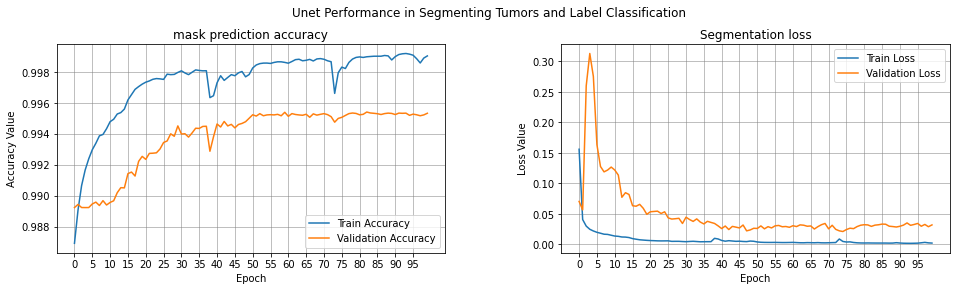

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
t = f.suptitle('Unet Performance in Segmenting Tumors and Label Classification', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['mask_accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_mask_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Mask_Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)
ax1.set_title("mask prediction accuracy")


ax2.plot(epoch_list, hist.history['mask_loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_mask_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)
ax2.set_title("Segmentation loss")

Text(0.5, 1.0, 'Label loss')

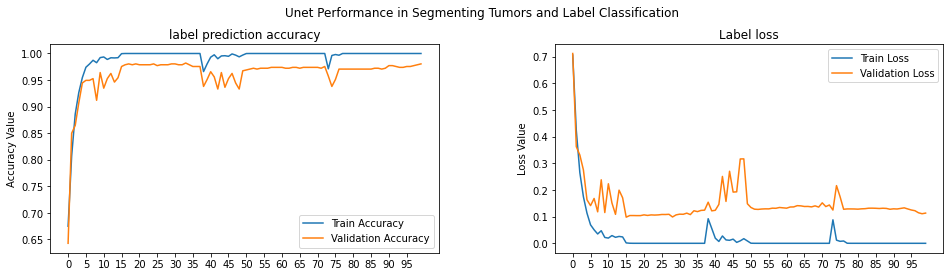

In [ ]:
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 4))
t = f.suptitle('Unet Performance in Segmenting Tumors and Label Classification', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax3.plot(epoch_list, hist.history['label_accuracy'], label='Train Accuracy')
ax3.plot(epoch_list, hist.history['val_label_accuracy'], label='Validation Accuracy')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax3.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)
ax3.set_title("label prediction accuracy")

ax4.plot(epoch_list, hist.history['label_loss'], label='Train Loss')
ax4.plot(epoch_list, hist.history['val_label_loss'], label='Validation Loss')
ax4.set_xticks(np.arange(0, epoch_list[-1], 5))
ax4.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax4.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)
ax4.set_title("Label loss")


Text(0.5, 1.0, 'Jaccard coef')

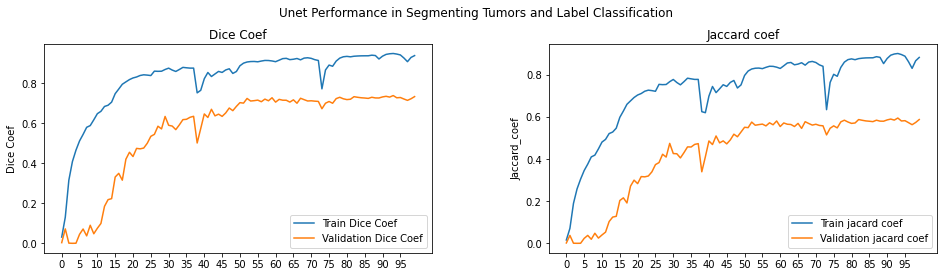

In [ ]:
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 4))
t = f.suptitle('Unet Performance in Segmenting Tumors and Label Classification', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax3.plot(epoch_list, hist.history['mask_dice_coef'], label='Train Dice Coef')
ax3.plot(epoch_list, hist.history['val_mask_dice_coef'], label='Validation Dice Coef')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('Dice Coef');ax1.set_xlabel('Epoch');ax1.set_title('Dice Coef')
ax3.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)
ax3.set_title("Dice Coef")

ax4.plot(epoch_list, hist.history['mask_jacard_coef'], label='Train jacard coef')
ax4.plot(epoch_list, hist.history['val_mask_jacard_coef'], label='Validation jacard coef')
ax4.set_xticks(np.arange(0, epoch_list[-1], 5))
ax4.set_ylabel('Jaccard_coef');ax2.set_xlabel('Epoch');ax2.set_title('Jaccard coef')
ax4.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)
ax4.set_title("Jaccard coef")


In [ ]:
THRESHOLD = 0.5
predicted_mask = (unet.predict(X_v)[0]>THRESHOLD)
predicted_label=np.argmax(unet.predict(X_v)[1],axis=-1)


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_p = predicted_label
y_t = labels2_val
print(y_p.shape)
print(y_t.shape)
print(confusion_matrix(y_t, y_p))
print(classification_report(y_t, y_p, labels=[0, 1, 2, 3]))

(613,)
(613, 1)
[[134   7   1]
 [  1 282   2]
 [  1   0 185]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       142
           1       0.98      0.99      0.98       285
           2       0.98      0.99      0.99       186
           3       0.00      0.00      0.00         0

   micro avg       0.98      0.98      0.98       613
   macro avg       0.74      0.73      0.73       613
weighted avg       0.98      0.98      0.98       613



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


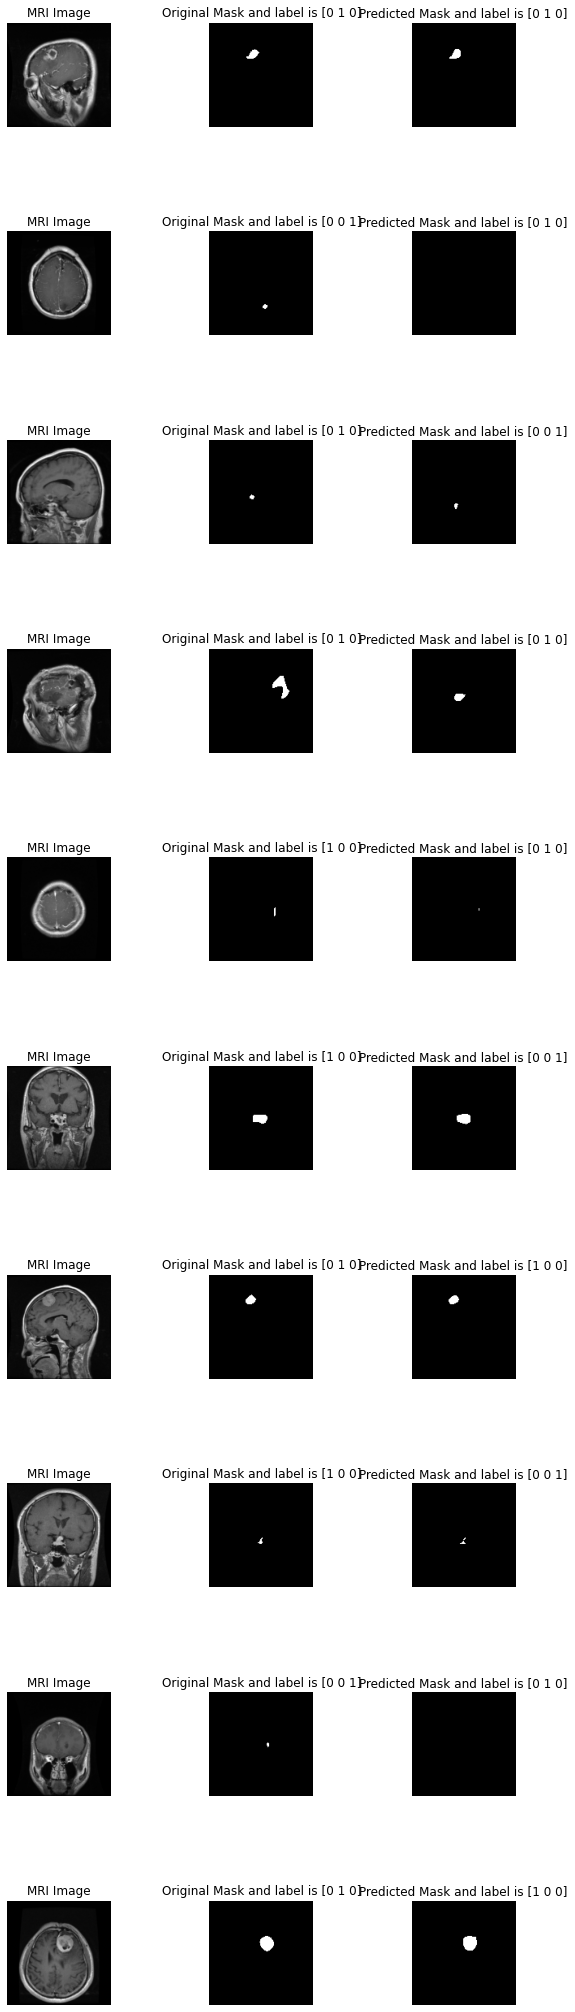

In [ ]:
plt.figure(figsize=(8,30),tight_layout=True)
i=1;total=10
temp = np.ones_like( Y_v[0] )
for idx in np.random.randint(0,high=X_v.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(Y_v[idx]), cmap='gray' )
    #plt.imshow( np.squeeze(temp - masks[idx], axis = -1), alpha=0.2, cmap='Dark2_r' )
    plt.title("Original Mask and label is {}".format(labels.values[idx]));plt.axis('off')
    
    b = np.zeros(3, dtype= int)
    t = predicted_label[idx]
    b[t] = 1
    #print(b)
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(predicted_mask[idx]), cmap='gray' )
    plt.title("Predicted Mask and label is {}".format(b));plt.axis('off')

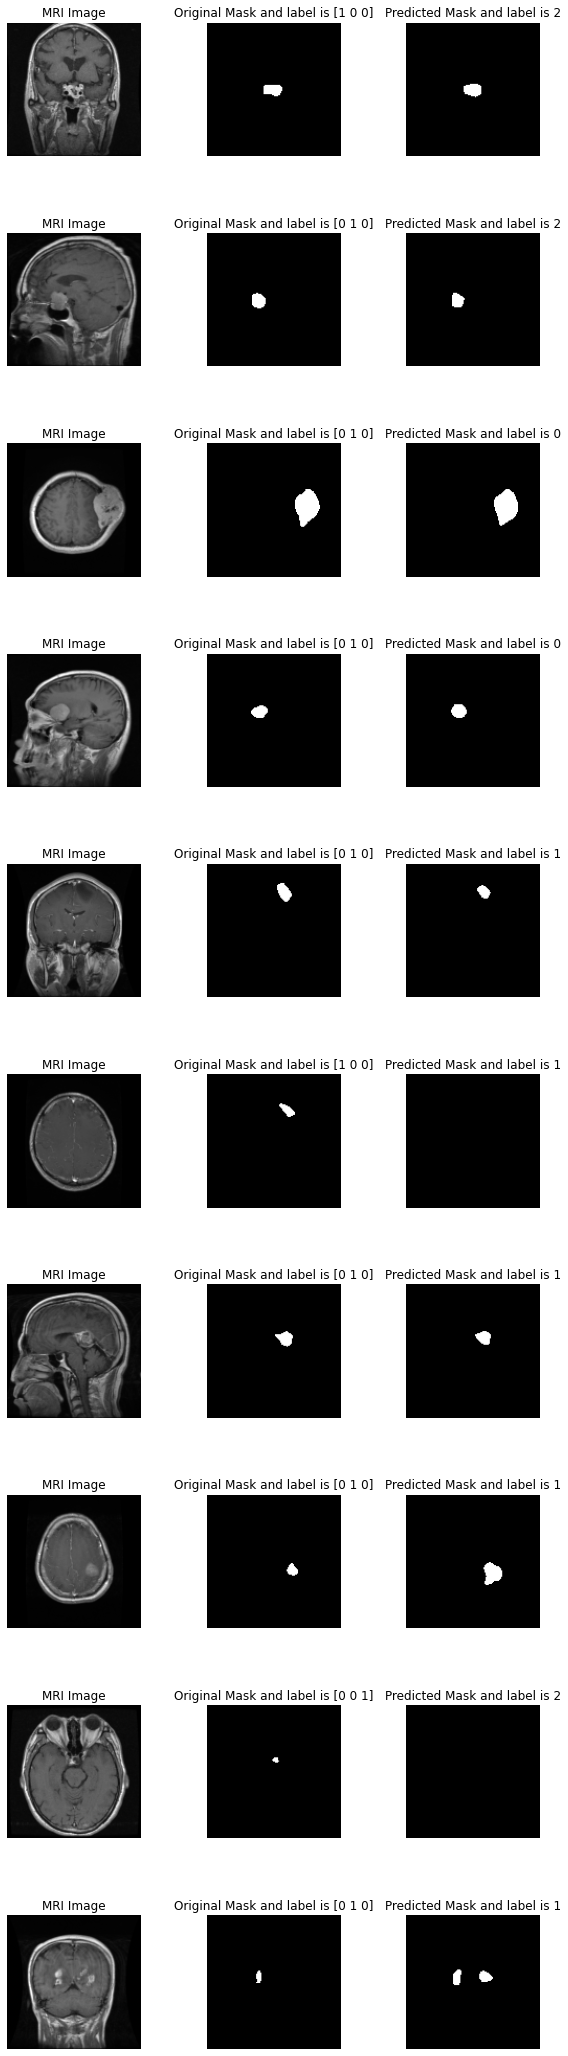

In [ ]:
plt.figure(figsize=(8,30),tight_layout=True)
i=1;total=10
temp = np.ones_like( Y_v[0] )
for idx in np.random.randint(0,high=X_v.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(Y_v[idx]), cmap='gray' )
    #plt.imshow( np.squeeze(temp - masks[idx], axis = -1), alpha=0.2, cmap='Dark2_r' )
    plt.title("Original Mask and label is {}".format(labels.values[idx]));plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(predicted_mask[idx]), cmap='gray' )
   # plt.imshow( np.squeeze(temp - predicted_mask[idx],axis=-1),  alpha=0.2, cmap='Greens' )
    plt.title("Predicted Mask and label is {}".format(predicted_label[idx]));plt.axis('off')